<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

In [ ]:
pip install transformers -U

     |████████████████████████████████| 1.8MB 12.7MB/s 
     |████████████████████████████████| 890kB 34.6MB/s 
     |████████████████████████████████| 2.9MB 43.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=2f1a5d84394309db811082c9a959971d00b8116f6f4ce6caa21a18a879dfe16c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import time
import sys
from google.colab import drive
import numpy as np
import json
import tarfile
import tensorflow as tf
import torch, torch.nn as nn
import torch.nn.functional as F
import random
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
if not tf.executing_eagerly():
  tf.compat.v1.enable_eager_execution()

## Базовая часть:

### 1. Предобработка текстов из датасета

In [ ]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:

sys.path.append('/content/gdrive/My Drive/DLS2sem/Image Captioning Project')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode

drive.mount('/content/gdrive')

DATA_PATH = 'gdrive/My Drive/DLS2sem/Image Captioning Project/'

Mounted at /content/gdrive


In [ ]:
tar = tarfile.open('gdrive/My Drive/DLS2sem/Image Captioning Project/handout.tar')
tar.extractall()

# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [ ]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))
print(len(captions))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .
118287


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [ ]:
train_captions=[]
img_encoded=[]

for num in range(len(img_codes)):
    captions_list=captions[num]
    train_captions.extend(captions_list)
    img_encoded.extend([img_codes[num]]*len(captions_list))

In [ ]:
for num in range(len(train_captions)):
  train_captions[num]=f"<sos> {train_captions[num]} <eos>"

In [ ]:
len(train_captions),len(img_encoded)

(591435, 591435)

In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
top_k= 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
padded_seqs=tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding='post',value=tokenizer.word_index['<pad>'])

In [ ]:
print(train_seqs[0])

591435
[3, 20, 1031, 9, 16, 135, 490, 80, 210, 5, 4]


In [ ]:
len(padded_seqs),len(img_encoded)

(591435, 591435)

Spliting

In [ ]:
imgs_and_seqs=list(zip(img_encoded,padded_seqs))
random.shuffle(imgs_and_seqs)
shuffled_imgs,shuffled_seqs=zip(*imgs_and_seqs)
slice_index = int(len(shuffled_imgs)*0.8)
train_imgs,val_imgs=shuffled_imgs[:slice_index],shuffled_imgs[slice_index:]
train_seqs,val_seqs=shuffled_seqs[:slice_index],shuffled_seqs[slice_index:]

In [ ]:
train_imgs=tf.squeeze(tf.convert_to_tensor(train_imgs,dtype=tf.float32))
train_seqs=tf.squeeze(tf.convert_to_tensor(train_seqs,dtype=tf.int32))

In [ ]:
train_imgs.shape,train_seqs.shape

(TensorShape([473148, 2048]), TensorShape([473148, 54]))

Dataset


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 500000
embedding_dim=512
voc_size=top_k+1
num_steps = len(train_imgs) // BATCH_SIZE

In [ ]:
dataset=tf.data.Dataset.from_tensor_slices((train_imgs,train_seqs))

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [ ]:
class CaptionNet(tf.keras.Model):
    def __init__(self, embedding_dim, units, cnn_feature_size=2048):
        super(self.__class__, self).__init__()
        self.units = units

        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        # 2. слой эмбедднга
        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        # 4. линейный слой для получения логитов
        
        self.fc_to_h0=tf.keras.layers.Dense(self.units)
        self.fc_to_c0=tf.keras.layers.Dense(self.units)
        self.embedding=tf.keras.layers.Embedding(voc_size,embedding_dim)
        self.lstm=tf.keras.layers.LSTM(self.units,return_sequences=True,recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(voc_size)

    def call(self, image_vectors,captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]

        Обратите внимание, что мы подаем сети на вход сразу все префиксы описания 
        и просим ее к каждому префиксу сгенерировать следующее слово!
        """
        
        # 1. инициализируем LSTM state
        # 2. применим слой эмбеддингов к image_vectors
        # 3. скормим LSTM captions_emb
        # 4. посчитаем логиты из выхода LSTM
        
        cell=self.fc_to_c0(image_vectors)
        hid=self.fc_to_h0(image_vectors)
        
        captions_emb=self.embedding(captions_ix)
        
        output=self.lstm(inputs=captions_emb,initial_state=[hid,cell])
        
        x=self.fc1(output)
        x=self.fc2(x)

        return x

In [ ]:
network = CaptionNet(embedding_dim,1024)

In [ ]:
loss_f=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adamax() # favourite one
start_epoch=0

In [ ]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    # реализуйте стандартный cross entropy loss: итоговый лосс есть сумма лоссов для каждого слова. 
    # 1. Получаем логиты, прогоняя image_vectors через сеть
    # 2. Вычисляем лосс-функцию между полученными логитами и captions_ix. Будьте внимательны: 
    # вычисляйте лосс между логитами, полученными из сети, и соответствующими им значениями из captions_ix!
    
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.
    
    loss=0
    captions_ix_inp = captions_ix[:, :-1]
    captions_ix_next = captions_ix[:, 1:]
    logits=network(image_vectors,captions_ix_inp)
    
    mask=tf.math.logical_not(tf.math.equal(captions_ix_next,tokenizer.word_index['<pad>'] ))

    loss = loss_f(captions_ix_next, logits)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.math.reduce_sum(loss)

CheckPoint

In [ ]:
checkpoint_path = "gdrive/My Drive/DLS2sem/Image Captioning Project/checkpoints/train"
ckpt = tf.train.Checkpoint(network,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = (int(ckpt_manager.latest_checkpoint.split('-')[-1])-1)*10
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
print(start_epoch)

10


## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [ ]:
loss_plot=[]

In [ ]:
def train_step(img_tensor, target):
  loss = 0

  with tf.GradientTape() as tape:
      loss = compute_loss(network,img_tensor,target)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables =network.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss , total_loss

In [ ]:
EPOCHS = 40
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss,t_loss = train_step(img_tensor, target)
        total_loss +=t_loss

        if batch % 1000 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy()/ int(target.shape[1]) ))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 10 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 11 Batch 0 Loss 23.7063
Epoch 11 Batch 1000 Loss 25.0834
Epoch 11 Batch 2000 Loss 25.7417
Epoch 11 Batch 3000 Loss 28.5274
Epoch 11 Batch 4000 Loss 25.6302
Epoch 11 Batch 5000 Loss 27.9123
Epoch 11 Batch 6000 Loss 25.6623
Epoch 11 Batch 7000 Loss 25.9332
Epoch 11 Loss 25.958872
Time taken for 1 epoch 591.0922472476959 sec

Epoch 12 Batch 0 Loss 22.1528
Epoch 12 Batch 1000 Loss 24.8427
Epoch 12 Batch 2000 Loss 23.4130
Epoch 12 Batch 3000 Loss 24.7935
Epoch 12 Batch 4000 Loss 24.3863
Epoch 12 Batch 5000 Loss 25.6560
Epoch 12 Batch 6000 Loss 22.2903
Epoch 12 Batch 7000 Loss 26.2928
Epoch 12 Loss 24.921638
Time taken for 1 epoch 567.3550975322723 sec

Epoch 13 Batch 0 Loss 21.9584
Epoch 13 Batch 1000 Loss 23.6328
Epoch 13 Batch 2000 Loss 20.7792
Epoch 13 Batch 3000 Loss 22.7143
Epoch 13 Batch 4000 Loss 22.0971
Epoch 13 Batch 5000 Loss 25.8476
Epoch 13 Batch 6000 Loss 24.7322
Epoch 13 Batch 7000 Loss 25.5465
Epoch 13 Loss 24.051741
Time taken for 1 epoch 571.4335994720459 sec

Epoch 1

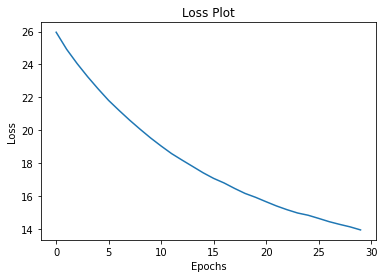

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Inseption и получение результатов


In [ ]:
network.summary()

Model: "caption_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2098176   
_________________________________________________________________
dense_1 (Dense)              multiple                  2098176   
_________________________________________________________________
embedding (Embedding)        multiple                  5120512   
_________________________________________________________________
lstm (LSTM)                  multiple                  6295552   
_________________________________________________________________
dense_2 (Dense)              multiple                  1049600   
_________________________________________________________________
dense_3 (Dense)              multiple                  10251025  
Total params: 26,913,041
Trainable params: 26,913,041
Non-trainable params: 0
___________________________________________

In [ ]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.6/dist-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


### Сгенерируем описание

In [ ]:
def generate_caption(image, t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        

        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        ans=['sos']
      
        caption_prefix=tf.expand_dims(tf.convert_to_tensor(tokenizer.word_index['<sos>']),0)

        # слово за словом генерируем описание картинки
        for _ in range(max_len):
            # 1. представляем caption_prefix в виде матрицы
            # 2. Получить из RNN-ки логиты, передав ей vectors_neck и матрицу из п.1
            # 3. Перевести логиты RNN-ки в вероятности (например, с помощью F.softmax)
            # 4. сэмплировать следующее слово в описании, используя полученные вероятности. Можно сэмплировать жадно 
            # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
            # 5. Добавляем новое слово в caption_prefix
            # 6. Если RNN-ка сгенерила символ конца предложения, останавливаемся
            
            vectors_neck=tf.convert_to_tensor(vectors_neck)

            logits=network(vectors_neck,tf.expand_dims(caption_prefix,0))
            logits=tf.nn.softmax(logits)

            word=tokenizer.index_word[tf.math.argmax(logits[0][-1],0).numpy()]
            ans.append(word)

            tokenized_word=tf.expand_dims(tf.convert_to_tensor(tokenizer.word_index[word]),0)
            caption_prefix=tf.squeeze(tf.concat((caption_prefix,tokenized_word),0))

            if word=='<eos>':
              break
            
    return ans

### Скачаем пару картинок, чтобы проверить качество:

In [ ]:
#from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255.

--2021-02-07 13:00:04--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-02-07 13:00:04--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0s      

2021-02-07 13:00:04 (124 MB/s) - ‘img.jpg’ saved [54731/

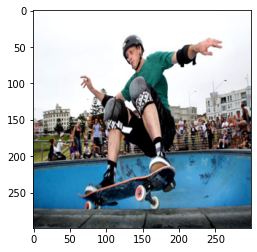

In [ ]:
plt.imshow(img)

In [ ]:
print(' '.join(generate_caption(img, t=5.)[1:-1]))

a skateboarder doing a jump with the skateboard still on the edge .


--2021-02-07 13:00:06--  https://cdn.trinixy.ru/pics5/20180420/thousand_words_01.jpg
Resolving cdn.trinixy.ru (cdn.trinixy.ru)... 88.99.67.6, 88.99.67.7
Connecting to cdn.trinixy.ru (cdn.trinixy.ru)|88.99.67.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53261 (52K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  52.01K  --.-KB/s    in 0.02s   

2021-02-07 13:00:06 (2.08 MB/s) - ‘img.jpg’ saved [53261/53261]



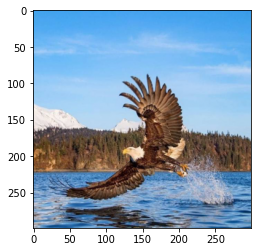

a large bird with a long beak sitting underneath a tree .


In [ ]:
!wget https://cdn.trinixy.ru/pics5/20180420/thousand_words_01.jpg -O img.jpg
img = plt.imread('img.jpg')
img=np.array(Image.fromarray(img).resize((299,299)))/255.

plt.imshow(img)
plt.show()

print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

--2021-02-07 13:00:07--  https://www.rosphoto.com/images/u/articles/1510/4_8.jpg
Resolving www.rosphoto.com (www.rosphoto.com)... 93.95.98.51
Connecting to www.rosphoto.com (www.rosphoto.com)|93.95.98.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1771609 (1.7M) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]   1.69M  6.13MB/s    in 0.3s    

2021-02-07 13:00:07 (6.13 MB/s) - ‘img.jpg’ saved [1771609/1771609]



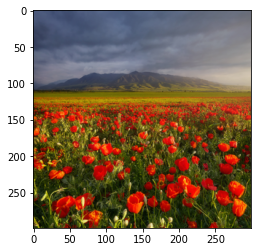

a field filled with lots of yellow and green flowers .


In [ ]:
!wget https://www.rosphoto.com/images/u/articles/1510/4_8.jpg -O img.jpg
img = plt.imread('img.jpg')
img=np.array(Image.fromarray(img).resize((299,299)))/255.

plt.imshow(img)
plt.show()

print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2021-02-07 13:00:08--  https://www.onetwotrip.com/ru/blog/wp-content/uploads/2017/07/good-photo.jpg
Resolving www.onetwotrip.com (www.onetwotrip.com)... 85.159.209.97
Connecting to www.onetwotrip.com (www.onetwotrip.com)|85.159.209.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104626 (102K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 102.17K  --.-KB/s    in 0.09s   

2021-02-07 13:00:09 (1.13 MB/s) - ‘img.jpg’ saved [104626/104626]



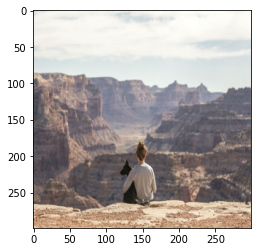

a man is standing on a rock by the ocean


In [ ]:
!wget https://www.onetwotrip.com/ru/blog/wp-content/uploads/2017/07/good-photo.jpg -O img.jpg
img = plt.imread('img.jpg')
img=np.array(Image.fromarray(img).resize((299,299)))/255.

plt.imshow(img)
plt.show()

print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2021-02-07 13:00:10--  https://sputnik.kg/images/104791/55/1047915505.jpg
Resolving sputnik.kg (sputnik.kg)... 176.126.167.188
Connecting to sputnik.kg (sputnik.kg)|176.126.167.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216681 (212K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 211.60K   316KB/s    in 0.7s    

2021-02-07 13:00:11 (316 KB/s) - ‘img.jpg’ saved [216681/216681]



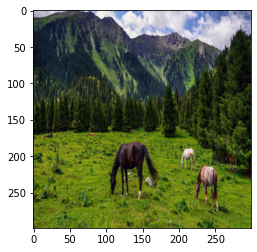

two horses stand in the grass near a hill and a rock beside the water .


In [ ]:
!wget https://sputnik.kg/images/104791/55/1047915505.jpg -O img.jpg
img = plt.imread('img.jpg')
img=np.array(Image.fromarray(img).resize((299,299)))/255.

plt.imshow(img)
plt.show()

print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2021-02-07 13:00:12--  https://ptici.info/assets/components/phpthumbof/cache/amur_kobchik.e4daf747db2e4ab4a26be96621b8a018.jpg
Resolving ptici.info (ptici.info)... 92.53.96.229, 2a03:6f00:1::5c35:60e5
Connecting to ptici.info (ptici.info)|92.53.96.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25457 (25K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  24.86K  --.-KB/s    in 0.003s  

2021-02-07 13:00:12 (7.55 MB/s) - ‘img.jpg’ saved [25457/25457]



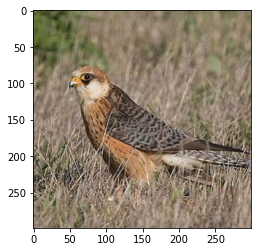

two identical birds stand in a field one and one is eating grass .


In [ ]:
!wget https://ptici.info/assets/components/phpthumbof/cache/amur_kobchik.e4daf747db2e4ab4a26be96621b8a018.jpg -O img.jpg
img = plt.imread('img.jpg')
img=np.array(Image.fromarray(img).resize((299,299)))/255.

plt.imshow(img)
plt.show()

print(' '.join(generate_caption(img, t=5.)[1:-1]))

## Бонус: Achtung

В качестве бонусного задания предлагается реализовать механизм attention в rnn-сети, которую мы писали в базовой части.